## Import Dependencies

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Training and Preprocessing Libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


from imblearn.over_sampling import SMOTE

## Read Data from csv

In [83]:
data_file_path = 'data/accidents_2012_to_2014.csv'
# Read csv as dataframe
data = pd.read_csv(data_file_path)
data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,201201BS70001,527200,178760,-0.169101,51.493429,1,3,2,1,19/01/2012,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002821,2012
1,201201BS70002,524930,181430,-0.200838,51.517931,1,3,2,1,04/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01004760,2012
2,201201BS70003,525860,178080,-0.188636,51.487618,1,3,2,1,10/01/2012,...,non-junction pedestrian crossing,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002893,2012
3,201201BS70004,524980,181030,-0.200259,51.514325,1,3,1,1,18/01/2012,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002886,2012
4,201201BS70005,526170,179200,-0.183773,51.497614,1,3,1,1,17/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002890,2012


## Visualize Data

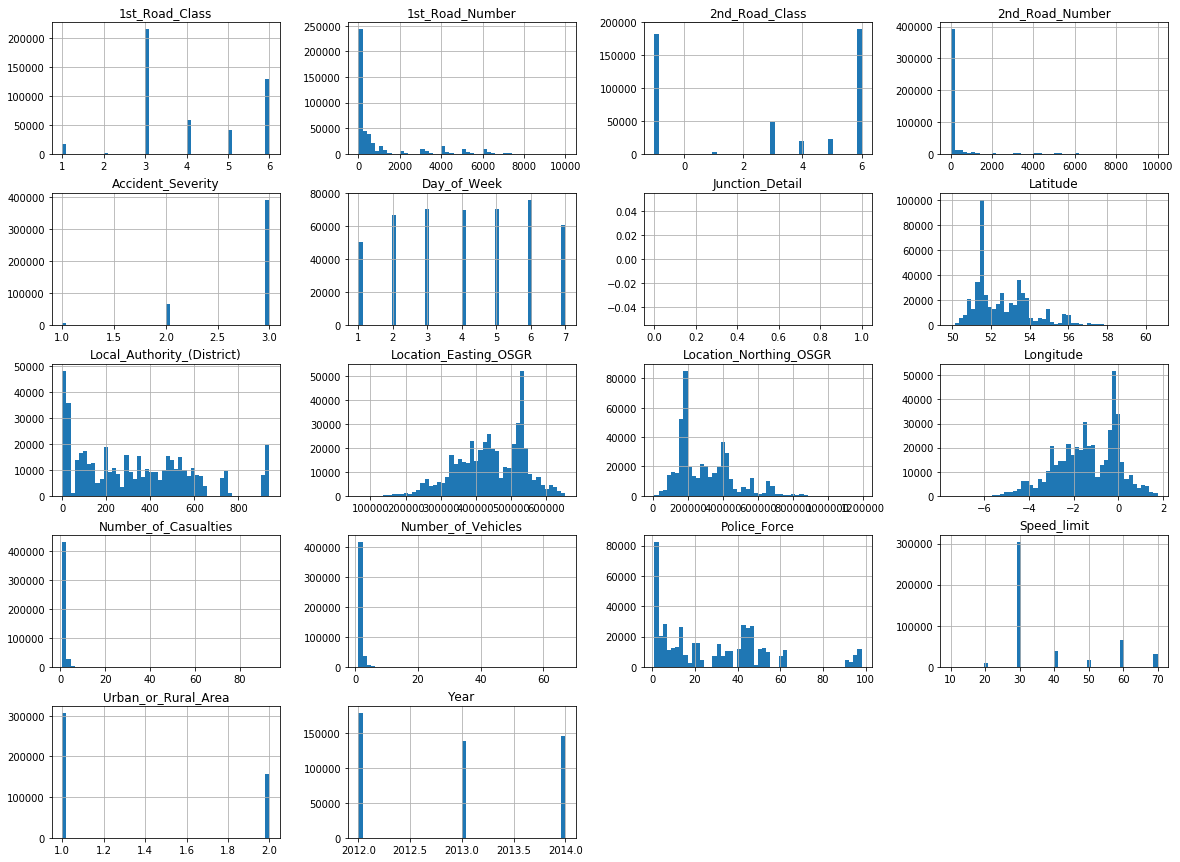

In [84]:
data.hist(bins=50, figsize=(20,15))
plt.show()

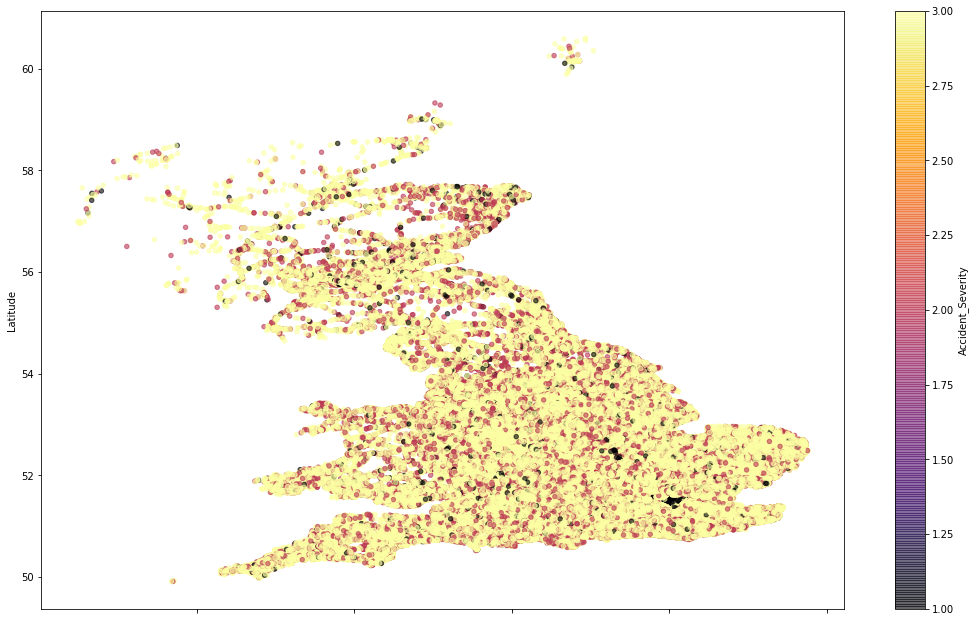

In [85]:
fig = data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.6,
                   figsize=(18,11),c="Accident_Severity", cmap=plt.get_cmap("inferno"), 
                   colorbar=True,)

## Correlation Matrix

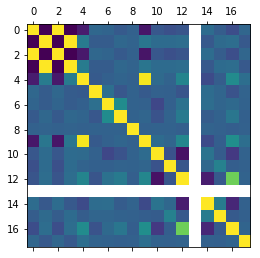

In [86]:
corr_matrix = data.corr() 
plt.matshow(corr_matrix)

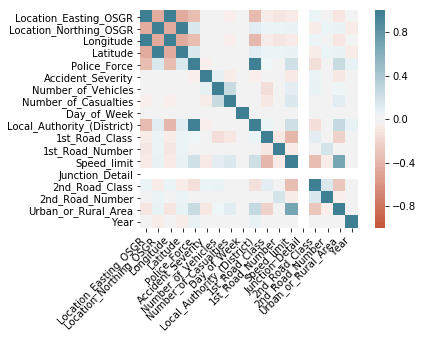

In [87]:
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig('correlation_matrix')

In [88]:
corr_matrix["Accident_Severity"].sort_values(ascending=False)

Accident_Severity             1.000000
Number_of_Vehicles            0.078750
2nd_Road_Class                0.059245
Location_Easting_OSGR         0.033165
Longitude                     0.033144
2nd_Road_Number               0.022077
Year                          0.006445
Day_of_Week                   0.003478
1st_Road_Class               -0.000410
1st_Road_Number              -0.007502
Location_Northing_OSGR       -0.031794
Latitude                     -0.031863
Police_Force                 -0.039979
Local_Authority_(District)   -0.043415
Number_of_Casualties         -0.060358
Speed_limit                  -0.073219
Urban_or_Rural_Area          -0.079522
Junction_Detail                    NaN
Name: Accident_Severity, dtype: float64

## Data Cleaning and Transformation

In [89]:
#Drop useless columns and nan values
data.drop(['Police_Force','Accident_Index','Date','Time', 'Junction_Detail', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Local_Authority_(District)', 'Local_Authority_(Highway)','Year'], axis=1, inplace=True)
data.dropna(inplace=True)

#Drop rows with 'Unknown' values
data = data[data.Weather_Conditions!='Unknown']
data = data[data.Road_Type!='Unknown']

In [90]:
 #Encode "String" Labels into "Int" Labels for easy training
le = LabelEncoder()
data["Pedestrian_Crossing-Physical_Facilities"]= le.fit_transform(data["Pedestrian_Crossing-Physical_Facilities"])
data["Light_Conditions"]= le.fit_transform(data["Light_Conditions"])
data["Weather_Conditions"] = le.fit_transform(data["Weather_Conditions"])
data["Road_Surface_Conditions"] = le.fit_transform(data["Road_Surface_Conditions"])
data["Pedestrian_Crossing-Human_Control"] = le.fit_transform(data["Pedestrian_Crossing-Human_Control"])
data["Road_Type"] = le.fit_transform(data["Road_Type"])

data["Junction_Control"] = le.fit_transform(data["Junction_Control"])

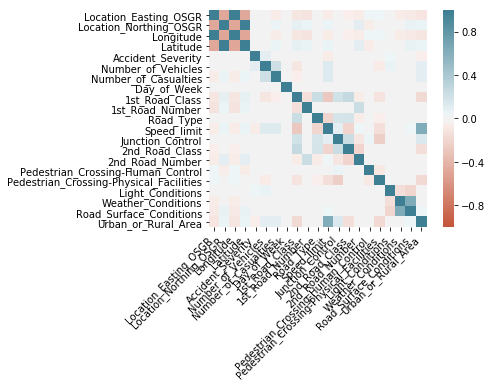

In [91]:
corr_matrix = data.corr()
ax = sns.heatmap(
    data.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig('correlation_matrix_refined')

In [92]:
corr_matrix["Accident_Severity"].sort_values(ascending=False)

Accident_Severity                          1.000000
Number_of_Vehicles                         0.094618
Light_Conditions                           0.041080
Location_Easting_OSGR                      0.027131
Longitude                                  0.027110
Weather_Conditions                         0.023156
Road_Surface_Conditions                    0.008088
2nd_Road_Number                            0.007574
Day_of_Week                                0.003969
Pedestrian_Crossing-Physical_Facilities    0.002892
Pedestrian_Crossing-Human_Control         -0.000573
1st_Road_Class                            -0.003201
1st_Road_Number                           -0.006372
Road_Type                                 -0.020290
Junction_Control                          -0.021009
Location_Northing_OSGR                    -0.021917
Latitude                                  -0.022012
Number_of_Casualties                      -0.026298
2nd_Road_Class                            -0.029117
Urban_or_Rur

## Data Normalization

In [93]:
X, Y = data.loc[:, data.columns != 'Accident_Severity'],data["Accident_Severity"]

In [94]:
X = StandardScaler().fit_transform(X)

## Splitting Data into train/test

In [95]:
trainX, testX, trainY, testY = train_test_split(X,Y,test_size=.25)
print(trainX.shape, testX.shape)

(210183, 20) (70062, 20)


In [96]:
def print_class_distribution(targets):
    target_count = targets.value_counts()
    print('Total Data points: ', len(targets))
    print('Class 1:', target_count[1], round(target_count[1]/len(targets)*100,4),'%')
    print('Class 2:', target_count[2], round(target_count[2]/len(targets)*100,4),'%')
    print('Class 3:', target_count[3], round(target_count[3]/len(targets)*100,4),'%')

In [97]:
print_class_distribution(trainY)

Total Data points:  210183
Class 1: 1486 0.707 %
Class 2: 27378 13.0258 %
Class 3: 181319 86.2672 %


In [98]:
print_class_distribution(testY)

Total Data points:  70062
Class 1: 503 0.7179 %
Class 2: 9108 12.9999 %
Class 3: 60451 86.2822 %


## Data Balancing to avoid Bias

In [99]:
sm = SMOTE(random_state=42)
trainX, trainY = sm.fit_resample(trainX, trainY)

In [100]:
print_class_distribution(trainY)

Total Data points:  543957
Class 1: 181319 33.3333 %
Class 2: 181319 33.3333 %
Class 3: 181319 33.3333 %


## Random Forest Classification

In [68]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Evaluating Random Forest

In [69]:
round(RF.score(testX,testY), 4)

0.7312

In [70]:
predictions = RF.predict(testX)
print(predictions[:10])

[3 3 3 3 3 3 3 3 3 3]


In [71]:
print(accuracy_score(testY, predictions))

0.7311666809397391


In [72]:
print(balanced_accuracy_score(testY, predictions))

0.4230881646555163


In [73]:
print(classification_report(testY, predictions))

              precision    recall  f1-score   support

           1       0.02      0.27      0.04       471
           2       0.20      0.18      0.19      9250
           3       0.88      0.82      0.85     60341

    accuracy                           0.73     70062
   macro avg       0.37      0.42      0.36     70062
weighted avg       0.79      0.73      0.76     70062



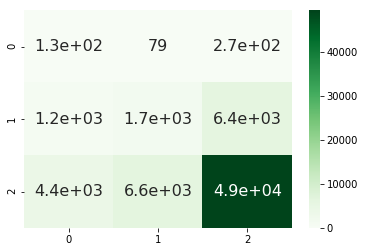

In [74]:
cm = confusion_matrix(testY, predictions)
sns.heatmap(cm, annot=True,annot_kws={"size": 16},cmap=plt.cm.Greens)# font size

In [75]:
scores = cross_val_score(RF, X, Y, cv=5)
print(scores)

[0.86270941 0.86272726 0.86270941 0.86270941 0.86267373]


In [76]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.00)


## Neural Network Classification

In [101]:
from sklearn.neural_network import MLPClassifier

In [112]:
mlp = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=100, alpha=0.01,
                    solver='adam', verbose=10, random_state=42, batch_size=16,
                    early_stopping=True, learning_rate='adaptive')

mlp.fit(trainX, trainY)

Iteration 1, loss = 0.87790039
Validation score: 0.641573
Iteration 2, loss = 0.78416682
Validation score: 0.663100
Iteration 3, loss = 0.76324382
Validation score: 0.666097
Iteration 4, loss = 0.75451798
Validation score: 0.679682
Iteration 5, loss = 0.74850363
Validation score: 0.675491
Iteration 6, loss = 0.74458185
Validation score: 0.687201
Iteration 7, loss = 0.74214321
Validation score: 0.682330
Iteration 8, loss = 0.73968051
Validation score: 0.683598
Iteration 9, loss = 0.73752977
Validation score: 0.690584
Iteration 10, loss = 0.73526069
Validation score: 0.681190
Iteration 11, loss = 0.73432852
Validation score: 0.682955
Iteration 12, loss = 0.73261678
Validation score: 0.692459
Iteration 13, loss = 0.73152190
Validation score: 0.686503
Iteration 14, loss = 0.73019119
Validation score: 0.686962
Iteration 15, loss = 0.72873035
Validation score: 0.689738
Iteration 16, loss = 0.72858910
Validation score: 0.692165
Iteration 17, loss = 0.72733512
Validation score: 0.687937
Iterat

MLPClassifier(activation='relu', alpha=0.01, batch_size=16, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

## Evaluating Neural Network Classifier

In [113]:
predictions = mlp.predict(testX)
print(predictions[:10])

[3 3 3 3 3 2 3 2 2 3]


In [114]:
print(accuracy_score(testY, predictions))

0.6210213810624875


In [115]:
print(classification_report(testY, predictions))

              precision    recall  f1-score   support

           1       0.03      0.31      0.05       503
           2       0.19      0.41      0.26      9108
           3       0.90      0.66      0.76     60451

    accuracy                           0.62     70062
   macro avg       0.37      0.46      0.35     70062
weighted avg       0.80      0.62      0.69     70062



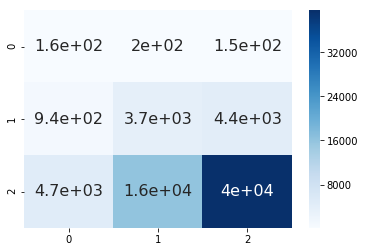

In [116]:
cm = confusion_matrix(testY, predictions)
sns.heatmap(cm, annot=True,annot_kws={"size": 16},cmap=plt.cm.Blues)# font size
plt.savefig('confusion_matrix_mlp')

In [110]:
scores = cross_val_score(mlp, X, Y, cv=4)
print(scores)

Iteration 1, loss = 0.42857175
Validation score: 0.859746
Iteration 2, loss = 0.41775975
Validation score: 0.859746
Iteration 3, loss = 0.41670195
Validation score: 0.859746
Iteration 4, loss = 0.41612198
Validation score: 0.859746
Iteration 5, loss = 0.41572166
Validation score: 0.859698
Iteration 6, loss = 0.41562116
Validation score: 0.859746
Iteration 7, loss = 0.41555181
Validation score: 0.859746
Iteration 8, loss = 0.41536643
Validation score: 0.859698
Iteration 9, loss = 0.41530244
Validation score: 0.859746
Iteration 10, loss = 0.41517882
Validation score: 0.859698
Iteration 11, loss = 0.41508468
Validation score: 0.859698
Iteration 12, loss = 0.41516998
Validation score: 0.859746
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.42942333
Validation score: 0.865312
Iteration 2, loss = 0.41855199
Validation score: 0.865312
Iteration 3, loss = 0.41735463
Validation score: 0.865312
Iteration 4, loss = 0.41679510
Val

In [108]:
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8627 (+/- 0.0000)
